# Experiment Notebook: Numerosity-Based Categorization
**Objective:**  
Train a CNN on the synthetic dot dataset (saved as `train_dataset.pt`, `val_dataset.pt`, and `test_dataset.pt`) to classify images into three categories (Few, Medium, Many).  

**Goals:**
- Run multiple experiments (5+ runs) to account for randomness.
- Perform hyperparameter tuning.
- Record results in tables and visualize training curves, confusion matrices, and classification reports.
- Use a validation set for hyperparameter tuning.


# Import Libraries and Setup Device

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Saved Datasets

In [7]:
class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [8]:
# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt")
val_dataset = torch.load("val_dataset.pt")
test_dataset = torch.load("test_dataset.pt")

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-8-80e23487e463>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load("train_dataset.pt")
<ipython-input-8-80e23487e463>:3: FutureWarnin

Train Dataset Size: 3500
Validation Dataset Size: 750
Test Dataset Size: 750


# Define the Model Architecture

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        # Input size 128x128 becomes 16x16 after 3 rounds of 2x2 pooling.
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # Three classes: Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

# Training and Evaluation Functions

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

def run_experiment(num_epochs=20, learning_rate=0.001, batch_size=32, early_stop_patience=3):
    # Create DataLoaders for the current run (can vary batch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = NumerosityCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # To store the training history
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

        # Early stopping check based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_accuracies

# Running Multiple runs

In [11]:
num_runs = 5
experiment_results = []

for run in range(num_runs):
    print(f"\n--- Starting Experiment Run {run+1}/{num_runs} ---")
    model, train_losses, val_losses, val_accuracies = run_experiment(num_epochs=20, learning_rate=0.001, batch_size=32)
    final_val_acc = val_accuracies[-1]
    final_val_loss = val_losses[-1]
    experiment_results.append({"Run": run+1, "Final Val Loss": final_val_loss, "Final Val Accuracy": final_val_acc})

# Create a DataFrame to display results
results_df = pd.DataFrame(experiment_results)
print("\nExperiment Run Results:")
print(results_df)


--- Starting Experiment Run 1/5 ---
Epoch [1/20], Train Loss: 1.0234, Val Loss: 0.3965, Val Acc: 84.27%
Epoch [2/20], Train Loss: 0.2287, Val Loss: 0.2136, Val Acc: 90.80%
Epoch [3/20], Train Loss: 0.1690, Val Loss: 0.3187, Val Acc: 87.47%
Epoch [4/20], Train Loss: 0.1537, Val Loss: 0.1724, Val Acc: 91.87%
Epoch [5/20], Train Loss: 0.1442, Val Loss: 0.1840, Val Acc: 91.73%
Epoch [6/20], Train Loss: 0.0995, Val Loss: 0.2033, Val Acc: 91.33%
Epoch [7/20], Train Loss: 0.0641, Val Loss: 0.2066, Val Acc: 92.53%
Early stopping triggered.

--- Starting Experiment Run 2/5 ---
Epoch [1/20], Train Loss: 0.7390, Val Loss: 0.3581, Val Acc: 84.80%
Epoch [2/20], Train Loss: 0.2390, Val Loss: 0.1775, Val Acc: 92.13%
Epoch [3/20], Train Loss: 0.2115, Val Loss: 0.1687, Val Acc: 93.20%
Epoch [4/20], Train Loss: 0.1434, Val Loss: 0.6191, Val Acc: 81.73%
Epoch [5/20], Train Loss: 0.1233, Val Loss: 0.3928, Val Acc: 88.53%
Epoch [6/20], Train Loss: 0.1166, Val Loss: 0.2338, Val Acc: 91.07%
Early stopping t

# Hyperparameter tuning (Grid search test)

In [12]:
hp_results = []
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n--- Hyperparameters: Learning Rate = {lr}, Batch Size = {bs} ---")
        model, train_losses, val_losses, val_accuracies = run_experiment(num_epochs=20, learning_rate=lr, batch_size=bs)
        final_val_acc = val_accuracies[-1]
        final_val_loss = val_losses[-1]
        hp_results.append({
            "Learning Rate": lr,
            "Batch Size": bs,
            "Final Val Loss": final_val_loss,
            "Final Val Accuracy": final_val_acc
        })

hp_results_df = pd.DataFrame(hp_results)
print("\nHyperparameter Tuning Results:")
print(hp_results_df)


--- Hyperparameters: Learning Rate = 0.001, Batch Size = 32 ---
Epoch [1/20], Train Loss: 0.8050, Val Loss: 0.3315, Val Acc: 87.07%
Epoch [2/20], Train Loss: 0.2555, Val Loss: 0.1985, Val Acc: 91.33%
Epoch [3/20], Train Loss: 0.2089, Val Loss: 0.2332, Val Acc: 89.33%
Epoch [4/20], Train Loss: 0.1753, Val Loss: 0.1826, Val Acc: 92.40%
Epoch [5/20], Train Loss: 0.1340, Val Loss: 0.2061, Val Acc: 90.80%
Epoch [6/20], Train Loss: 0.1213, Val Loss: 0.2095, Val Acc: 90.13%
Epoch [7/20], Train Loss: 0.0788, Val Loss: 0.2687, Val Acc: 88.93%
Early stopping triggered.

--- Hyperparameters: Learning Rate = 0.001, Batch Size = 64 ---
Epoch [1/20], Train Loss: 2.1884, Val Loss: 0.2588, Val Acc: 90.00%
Epoch [2/20], Train Loss: 0.2283, Val Loss: 0.1896, Val Acc: 92.53%
Epoch [3/20], Train Loss: 0.1674, Val Loss: 0.1729, Val Acc: 92.53%
Epoch [4/20], Train Loss: 0.1747, Val Loss: 0.1696, Val Acc: 93.07%
Epoch [5/20], Train Loss: 0.1169, Val Loss: 0.1663, Val Acc: 93.60%
Epoch [6/20], Train Loss: 0.

# Evaluation of Test set & visualization

Test Loss: 0.1998, Test Accuracy: 91.87%


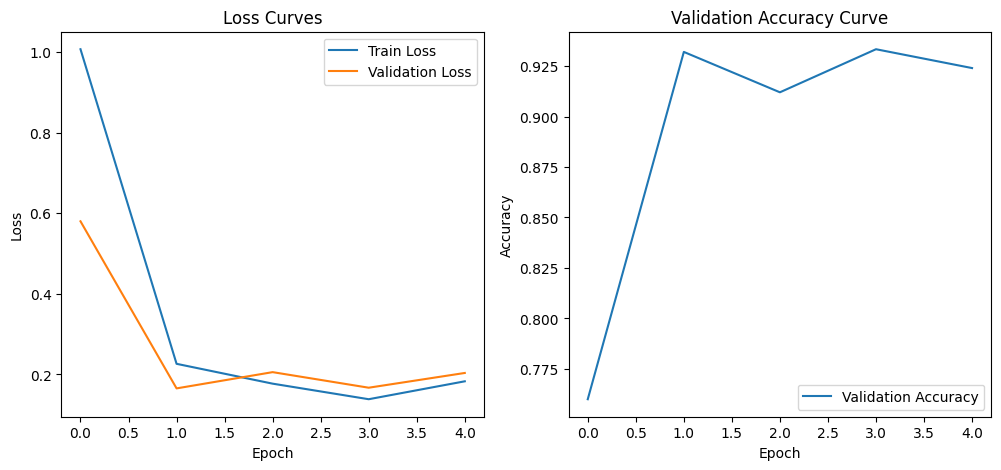

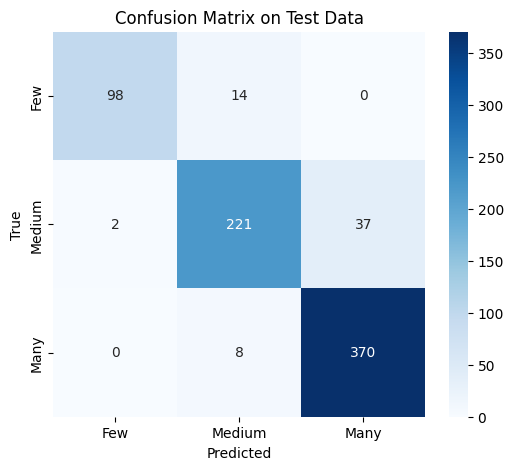

Classification Report:
              precision    recall  f1-score   support

         Few       0.98      0.88      0.92       112
      Medium       0.91      0.85      0.88       260
        Many       0.91      0.98      0.94       378

    accuracy                           0.92       750
   macro avg       0.93      0.90      0.92       750
weighted avg       0.92      0.92      0.92       750



In [13]:
# Evaluate the best model (or a chosen model) on the test set
# For simplicity, we load a model from the last run (you could choose the best among runs)

# Load the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()

# Evaluate the model on test data
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

# ----------------------------
# Visualization: Plot Loss and Accuracy Curves for the Last Run
# ----------------------------
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.show()

# ----------------------------
# Confusion Matrix and Classification Report on Test Data
# ----------------------------
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Few", "Medium", "Many"],
            yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Save final model & results

In [14]:
# Save the final best model from the last run (or choose one from hyperparameter tuning)
torch.save(model.state_dict(), "final_numerosity_model.pth")
print("Final model saved as 'final_numerosity_model.pth'.")

# Save experiment results to CSV for reproducibility
results_df.to_csv("experiment_run_results.csv", index=False)
hp_results_df.to_csv("hyperparameter_tuning_results.csv", index=False)
print("Experiment results saved as CSV files.")


Final model saved as 'final_numerosity_model.pth'.
Experiment results saved as CSV files.
